# Omdena Safecity Challenge #

### Author: Angelo Antonio Manzatto ###

--------------
## Problem Statement ##

Safecity gets hundreds of data points about crime and harassment rate about any geographical area through reports, audits and tips. We also have multiple data points about nearby police station, hospitals, toilets, quality of street lights about an area.

--------------

##  Expectation ##

The module should help in **clustering geography into heatmap of safe and unsafe**. The areas can be color-coded based on the difference in their safety level based on reports density, quality of issues, external data. It can also find similar areas in other parts of the world and help in taking preventive action.

--------------

## Proposed Solution ##

Build **machine learning models** capable of predicting a heatmap that clusters an already pre stablished region into different levels of safety. 

--------------

## Target Maps ##

For this project Delhi and Mumbai cities were selected as target because most of the dataset avaliable for this project is located on those places.

![selected maps](images/selected_maps.png)

# Problem Definitions #

It is important to understand what a heatmap is before jumping into coding. According to the Oxford dictionary heatmap is *A graphical representation of data in which a spectrum of colours is used to represent the different values*.

For us *graphical representation* will be expressed in a form of a grid matrix layed on top of a region in a map and the different colors will represent the risk intensity for women to suffer any kind of crime on that area.

Below is an example of a heatmap showing different crime intensity regions on Delhi in a certain moment. The black **dots** represents crimes that happend on that day.

![delhi_heatmap_prediction](images/delhi_heatmap_prediction.png)

Heatmaps are just pictures in time that represents a particular state of a certain situations. They vary from period to period and a scenario in the past is not necessarily the same in the present. That is one of the reasons we have to look at heatmap prediction challenge as a 3D problem. 

Looking at a heatmap from above we just see the 2D dimension, also called **Spatial Dimension**, but we also need to look how they change over time, the **Temporal Dimension**


# Spatial Dimension #

On the spatial dimension we decide the best resolution that we divide our map into a grid.

![spatial_dimension](images/spatial_dimension.png)



# Temporal Dimension #

On the temporal dimension we decide the time granularity that we group the incidents in a heatmap. They can stacked in hours, days, months and so on. 

![temporal_dimension](images/temporal_dimension.png)

In [28]:
##################################################################################
# Libraries
##################################################################################  
import os
import random
from datetime import timedelta  

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from utils import create_idx, find_best_bounding_map 
from utils import evaluate_model, find_percentiles
from utils import billinear_interpolation

from keras.models import Model

from keras.layers import Input, Dropout
from keras.layers import BatchNormalization
from keras.layers import Conv3D, ConvLSTM2D, MaxPooling3D

import keras.backend as K

from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

from keras.optimizers import Adam

np.random.seed(42) # My nickname Recruta42


In [2]:
############################################################################################
# Load Dataset
############################################################################################
dataset_folder = 'dataset'

dataset_file = os.path.join(dataset_folder,'SafetyDelhi.csv')

df = pd.read_csv(dataset_file)

df.head()

,incident,latitude,longitude
0,2019-09-04 17:00:00,28.527926,77.220591
1,2018-01-10 19:00:00,28.643303,77.179705
2,2018-06-30 16:00:00,28.632986,77.219374
3,2018-08-07 19:00:00,28.683396,77.208465
4,2018-03-06 19:00:00,28.680459,77.215037


## Data Cleaning ##

In [3]:
############################################################################################
# Cleaning Dataset
############################################################################################

##################################################################
# Create timestamp
##################################################################

# Rename columns to lowercase for easy access on pandas
df = df.rename(columns={"incident": "incident_date", "latitude": "lat", "longitude" : "lon"})

# Create timestamp column in format Year, Month, Day , Hour
df['ts'] = pd.to_datetime(df['incident_date'].apply(lambda x :x.split('-')[0]+ 
                                                                          x.split('-')[1]+ 
                                                                          x.split('-')[2][0:2]+
                                                                          x[11:13]), format='%Y%m%d%H')
# Convert latitude and longitude to float 
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

df.head()

,incident_date,lat,lon,ts
0,2019-09-04 17:00:00,28.527926,77.220591,2019-09-04 17:00:00
1,2018-01-10 19:00:00,28.643303,77.179705,2018-01-10 19:00:00
2,2018-06-30 16:00:00,28.632986,77.219374,2018-06-30 16:00:00
3,2018-08-07 19:00:00,28.683396,77.208465,2018-08-07 19:00:00
4,2018-03-06 19:00:00,28.680459,77.215037,2018-03-06 19:00:00


## Data Selection - Spatial Dimension ##

### Select Boundaries ###

If we select the entire dataset to use to our model we will verify that we will end up with a very sparse matrix where most of the values will always be zero. That happens because the aggregation of the incidents distribution is *not* uniformly distributed around the map. 

In order to avoid modeling this imprecise data we need to wipe out those reported entries that fall outside of the regios which most of the incidents are concentrated.

The approace used for this, using the method `find_best_bounding_map` was the following pipeline
* Group all the reported incidents into a defined grid.
* Flat the matrix vertically and horizontaly.
* Find the first spots on both above directions that bypass a predefine threshold.

Min Lat: 28.448845999999996 , Max Lat: 28.846687
Min Lon: 76.95045300000002 , Max Lon: 77.33984799999998


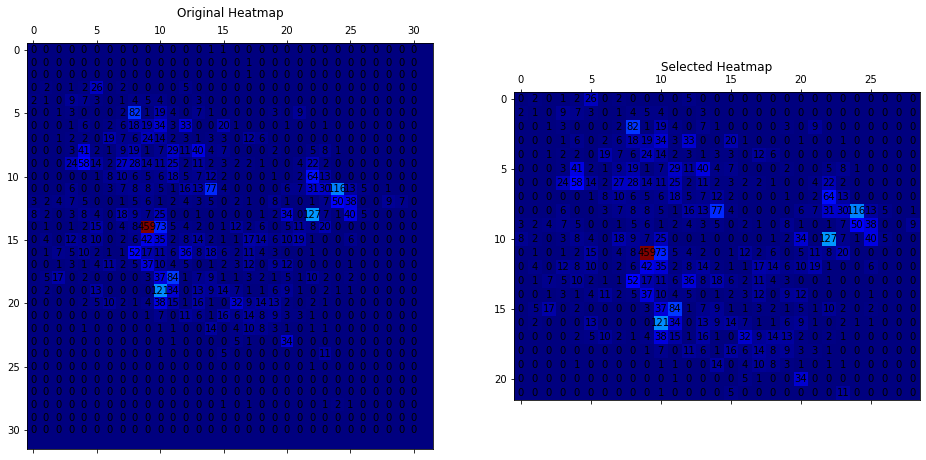

In [4]:
##################################################################
# Select region of interest for majority of  occurencces
##################################################################

# We will select just part of the dataset the majority of incidents are aggregated
# Increase the threshold if we are still returning a selected map with too many zeroes on borders.
best_bound_df = find_best_bounding_map(df, grid=(32,32), threshold = 10)

# Select just usefull columns
best_bound_df = best_bound_df[['ts','lat','lon']]

# Sort values by time stamp
best_bound_df = best_bound_df.sort_values(by='ts')

## Data Selection - Temporal Dimension ##

### Select Time Interval ###

We will check here where data concentrates on time dimension.

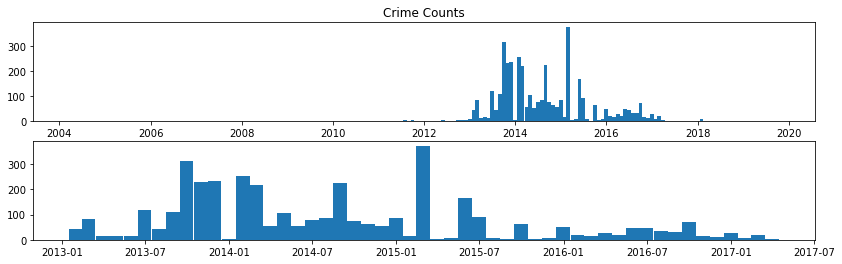

In [6]:
# Groupby frequency
freq ='M'

crime_sum = best_bound_df.groupby([pd.Grouper(key='ts', freq=freq)]).size()   
crime_sum = crime_sum.reset_index()
crime_sum.rename(columns ={0:'total'},inplace=True)

# Select between range where most of data is concentrated
start_date = '2013-01-01 00:00:00'
end_date = '2017-03-31 00:00:00'

crime_sum_selected = best_bound_df[(best_bound_df['ts'] > start_date) & (best_bound_df['ts'] < end_date)]
crime_sum_selected = crime_sum_selected.groupby([pd.Grouper(key='ts', freq=freq)]).size()   
crime_sum_selected = crime_sum_selected.reset_index()
crime_sum_selected.rename(columns ={0:'total'},inplace=True)

# define the size of images
f, (ax1,ax2) = plt.subplots(2,1)
f.set_figwidth(14)
f.set_figheight(4)

ax1.set_title("Crime Counts")

ax1.bar(crime_sum['ts'], crime_sum['total'], width=np.timedelta64(30, 'D'))
ax2.bar(crime_sum_selected['ts'], crime_sum_selected['total'], width=np.timedelta64(30, 'D'))

# Dataframe with just rows on the range selected dates
selected_date_df = best_bound_df[(best_bound_df['ts'] > start_date) & (best_bound_df['ts'] <= end_date)]

In [7]:
############################################################################################
# Save Processed Dataset 
############################################################################################
selected_date_df.to_csv(os.path.join(dataset_folder,'incidents_df.csv'), index=False)

In [8]:
############################################################################################
# Load dataset
############################################################################################
dataset_file = os.path.join(dataset_folder,'incidents_df.csv')
incidents_df = pd.read_csv(dataset_file)

# Convert object to timestamp
incidents_df['ts'] = pd.to_datetime(incidents_df['ts'])

incidents_df.head()

,ts,lat,lon
0,2013-01-04 15:00:00,28.506054,77.220397
1,2013-01-08 21:00:00,28.553534,77.299175
2,2013-01-09 11:00:00,28.562230,77.289725
3,2013-01-10 01:00:00,28.673312,77.170044
4,2013-01-10 01:00:00,28.719887,77.125978


## Data Pre Processing ##

On this part we construct the heatmap incidents based on date and grid position (h,w)

![data_preprocessing](images/data_preprocessing.png)

In [9]:
############################################################################################
# Create heatmaps
############################################################################################

# Hyperparameters for heatmap construction
T = 1 # Period frequency 1, 2, 3 ,4 
freq = 'D' # Date frequency that can be D, W, M for Days, Weeks, Months and so on
map_height = 32 # Number of zones that the map will be divided vertically 
map_width = 32  # Number of zones that the map will be divided horizontally

# Define the grid which we want to use to divide your map into zones
grid = (map_height,map_width)

# Map (lon, lat) into (grid_h, grid_w)
df_indexed = create_idx(incidents_df, grid)

# Aggregate (time, square, category) to create the incident map sum 
df_indexed_count = df_indexed.groupby(['grid_h','grid_w', pd.Grouper(key='ts', freq=freq)],as_index=True).size()    
df_indexed_count = df_indexed_count.reset_index()    
df_indexed_count.rename(columns ={0:'total'},inplace=True)

df_indexed_count = df_indexed_count.sort_values(by=['ts'])

Min Lat: 28.490664000000002 , Max Lat: 28.75911
Min Lon: 76.990485 , Max Lon: 77.33984799999998


In [10]:
############################################################################################
# Create our data as dictionary for easy access composed of tuples (heatmap, coords) selected by date key
############################################################################################
data = {}

for ts in df_indexed_count.ts.unique():
    
    #print("Processing data: {0}".format(ts))
    
    # Select data just for this timestamp
    points_by_date = df_indexed_count[df_indexed_count.ts == ts]
    
    # Create heatmap
    heatmap = np.zeros(grid)
    
    # Get incident coordinates
    crime_coords = []
    
    # Parse crime incident and heatmap
    for index, row in points_by_date.iterrows():
        crime_coords.append((row['grid_h'],row['grid_w']))
        
        heatmap[int(row['grid_h'])][int(row['grid_w'])] += 1
    
    crime_coords = np.asarray(crime_coords)
    
    # Store tuple heatmap and crime coordinates on dictionary
    data[pd.to_datetime(ts)] = (heatmap, crime_coords)

print("Data size: {0}".format(len(data)))

Data size: 583


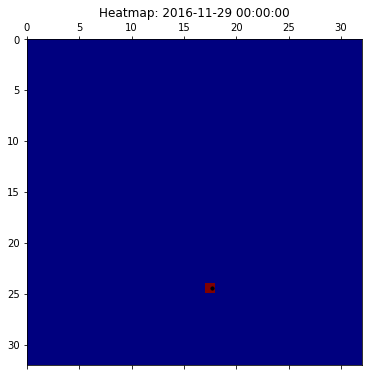

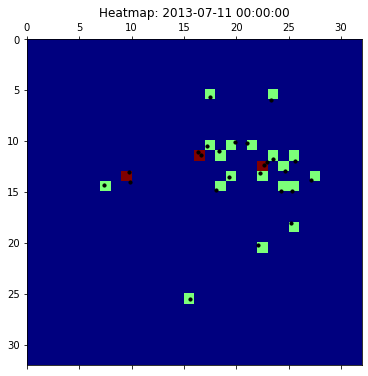

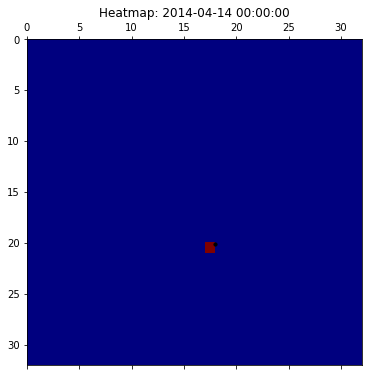

In [16]:
############################################################################################
# Plot random Samples
############################################################################################
   
# Plot some samples
n_samples = 3

for i in range(n_samples):

    # randomly select a sample
    date = random.choice(list(data.keys()))
    
    # Get heatmap aggregation and incident coordinates
    heatmap, coords = data[date]
    
    # define the size of images
    f, ax = plt.subplots()
    f.set_figwidth(6)
    f.set_figheight(6)
    
    ax.set_title("Heatmap: {0}".format(date))
    
    ax.scatter(x=coords[:,1],y=coords[:,0], marker='o', s=10, color='black') 
    ax.matshow(heatmap, cmap='jet',aspect = ax.get_aspect(), extent = (0,map_height) + (map_width,0))

In [17]:
################################
# Checking missing data
################################
def checking_missing_date(data):
    
    curr_date = min(data.keys())
    final_date = max(data.keys())

    missing_dates = []
    while (curr_date < final_date):
        
        if curr_date not in data:
            missing_dates.append(curr_date)
        
        curr_date += timedelta(days= T)
    
    print("Total dates: {0}".format(len(data)))      
    print("Missig dates: {0}".format(len(missing_dates)))
    print("Missig rate: {0:.2f} ".format(len(missing_dates) / len(data)))
    
    return missing_dates

missing_dates = checking_missing_date(data)

Total dates: 583
Missig dates: 963
Missig rate: 1.65 


In [18]:
#################################################
# Data augmentation using linear interpolation
#################################################
for ts in missing_dates:
    
    # Get previous ts
    prev_ts = ts
    next_ts = ts
    prev_data = None
    next_data = None
    
    # Find previous data
    while(prev_data is None):
        selected_ts = prev_ts - timedelta(days= T)
        
        if  selected_ts in data:
            prev_data = data[selected_ts]
            
        prev_ts -= timedelta(days= T)
    
    # Find next data
    while(next_data is None):
        selected_ts = next_ts + timedelta(days= T)
        
        if  selected_ts in data:
            next_data = data[selected_ts]
            
        next_ts += timedelta(days= T)
        
    #print("Missing: {0} , Prev: {1}. Next: {2}".format(ts,prev_ts,next_ts))
    
    # Make linear interpolation
    delta = (next_ts.date() - prev_ts.date()).days / T
    
    heatmap = (next_data[0] + prev_data[0]) / delta
    
    # Get aproximated synthetic coordinates
    crime_coords = np.argwhere(heatmap > 0)
    
    # Add entry to our data
    data[ts] = (heatmap,crime_coords)

checking_missing_date(data)

Total dates: 1546
Missig dates: 0
Missig rate: 0.00 


[]

In [19]:
############################################################################################
# Create Train / Target data
############################################################################################
   
period = 16
period_range =  [T * x for x in range(1,period+1)]
period_range.reverse()

strides = 1

curr_date = min(data.keys()) + timedelta(days=period * T)
last_date = max(data.keys())

# If we don't have a heatmap for specific date use the zero heatmap
heatmap_null = np.zeros(grid)

X, Y, Y_timestamp, Y_coords = [], [], [], []

while(curr_date < last_date):
    
    selected_date = curr_date
    
    # Increment the current timestep to the next stride
    curr_date = curr_date + timedelta(days=strides * T)
    
    # Check if there is data for this timestamp
    if selected_date in missing_dates:
        # print("Skipping {0}".format(selected_date))
        continue
    
    # print("Processing {0}".format(selected_date))
    
    # Select all heatmaps for the past timestemps in range of period range
    selected_heatmaps = []
    
    for c in period_range:
        
        ts = selected_date - timedelta(days=c)
        
        if ts not in data:
            selected_heatmaps.append(heatmap_null)
        else:
            # Select heatmap from dictionary
            heatmap = data[ts][0]
           
            # Add heatmap to stack for future prediction
            selected_heatmaps.append(heatmap)
       
      
    selected_heatmaps = np.stack(selected_heatmaps,axis=-1)
    selected_heatmaps = selected_heatmaps[np.newaxis,...]

    target_heatmap = np.expand_dims(data[selected_date][0],axis=-1)
    target_heatmap = target_heatmap[np.newaxis,...]
    
    X.append(selected_heatmaps)
    Y.append(target_heatmap)
    Y_timestamp.append(selected_date)
    Y_coords.append(data[selected_date][1])
    
X = np.asarray(X)
Y = np.asarray(Y)

print("X shape: ", X.shape)
print("Y_total: ", Y.shape)   

X shape:  (575, 1, 32, 32, 16)
Y_total:  (575, 1, 32, 32, 1)


## Classification Problem ## 

We will turn our problem from regression to classification

![data_preprocessing](images/binary_map.png)

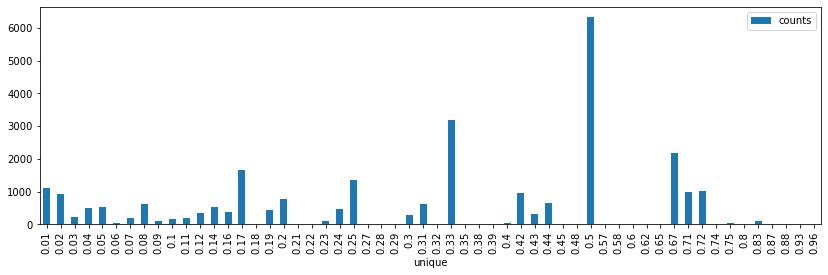

In [20]:
############################################################################################
# Check upsampled values between [0,1] excluded
############################################################################################
unique, counts = np.unique(np.around(X, 2), return_counts=True)

value_counts = pd.DataFrame({'unique': unique, 'counts': list(counts)}, columns=['unique', 'counts'])

# Since we want to evaluate just the values between zero and one excluding these we will make another selection
value_counts = value_counts[(value_counts.unique > 0) & (value_counts.unique < 1)]
value_counts.set_index('unique').plot(kind='bar', figsize=(14, 4))

In [21]:
############################################################################################
# Convert Heatmaps into Binarymaps
############################################################################################
X_scaled = X.copy()
Y_scaled = Y.copy()

# Threshold for binary map clipping
threshold = 0.5

X_scaled[X_scaled >= threshold] = 1.0
X_scaled[X_scaled < threshold] = 0.0

Y_scaled[Y_scaled >= threshold] = 1.0
Y_scaled[Y_scaled < threshold] = 0.0

print("X max: {0}, min {1}".format(X.max(),X.min()))
print("Y max: {0}, min {1}".format(Y.max(),Y.min()))

print("X_scaled max: {0}, min {1}".format(X_scaled.max(),X_scaled.min()))
print("Y_scaled max: {0}, min {1}".format(Y_scaled.max(),Y_scaled.min()))

X max: 10.0, min 0.0
Y max: 10.0, min 0.0
X_scaled max: 1.0, min 0.0
Y_scaled max: 1.0, min 0.0


# Train / Test #

On this section we divide our X, Y data into training set that will be used for training our model and a test set to validate the model.

It is important to highlight that the selected timestamps for Training / Test split excludes the **upsampled** heatmaps for target since we don't want to test our predictions on a synthetic data. 

In [22]:
############################################################################################
# Split dataset into Train / Test
############################################################################################

# Select just data that belongs to the selected year    
year = 2016 
month = 7

ts_selected = [x for x in Y_timestamp if x.year == year and x.month >= month]  
 
start_date = min(ts_selected)
end_date = max(ts_selected)

start_idx = Y_timestamp.index(start_date)
end_idx = Y_timestamp.index(end_date) + 1

# Split dataset into  / test sets
X_train, Y_train, Y_coords_train = X_scaled[:start_idx], Y_scaled[:start_idx], Y_coords[:start_idx]
X_test,  Y_test, Y_coords_test = X_scaled[start_idx:end_idx], Y_scaled[start_idx:end_idx],Y_coords[start_idx:end_idx]

# Time stamp split so we can track the period
timestamp_train, timestamp_test = Y_timestamp[:start_idx], Y_timestamp[start_idx:end_idx]

print("X Train size: ", len(X_train))
print("X Test size: ", len(X_test))    

X Train size:  481
X Test size:  83


# Model #

A good aproach for dealing with a problem of temporal and spatial dimension at the same time is to use a deep learning model using Convolutional + LSTM (Long Short Term Memory)

![model](images/model.png)

In [23]:
############################################################################################
# Model
############################################################################################  
def ConvLSTM(input_shape=(1,32,32,16)):
    
    heatmaps, height, width, channels = input_shape
    
    Image = Input(shape=input_shape)
   
    x = ConvLSTM2D(8, kernel_size=(3,3),strides=(1,1), padding="same", return_sequences=True)(Image)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2,1,1), strides=(2,1,1), padding='same')(x)
    
    x = Dropout(0.4)(x)
    
    x = ConvLSTM2D(4, kernel_size=(3,3),strides=(1,1), padding="same", return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2,1,1), strides=(2,1,1), padding='same')(x)
    
    x = Dropout(0.4)(x)
    
    x = ConvLSTM2D(2, kernel_size=(3,3),strides=(1,1), padding="same", return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2,1,1), strides=(2,1,1), padding='same')(x)
    
    x = Dropout(0.4)(x)
    
    x = ConvLSTM2D(1, kernel_size=(3,3),strides=(1,1), padding="same", return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2,1,1), strides=(2,1,1), padding='same')(x)
    
    x = Dropout(0.4)(x)
    
    final_output = Conv3D(1, kernel_size=(1,3,3), padding='same', activation='sigmoid')(x)
    
    model = Model(inputs=Image, outputs=final_output)
    
    return model

# Loss #

Heatmaps are very large sparse matrices (matrix with lots of zeroes), so to equilibrated the loss that naturally towards to the easy way meaning learning to predict only zeros we use a weighted cross entropy function to put more emphasis on missing ones.

In [24]:
############################################################################################
# Loss - Weightned Binary CrossEntropy
############################################################################################
def weighted_binary_crossentropy( y_true, y_pred, weight=5.) :
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1)

In [25]:
############################################################################################
# Training pipeline
############################################################################################

# Hyperparameters
epochs = 100
batch_size = 8
learning_rate = 0.0001

# callbacks
model_path = 'saved_models'

# File were the best model will be saved during checkpoint     
model_file = os.path.join(model_path,'model.h5')

# Early stop to avoid overfitting our model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Check point for saving the best model
check_pointer = ModelCheckpoint(model_file, monitor='val_loss', mode='min',verbose=1, save_best_only=True)

# Logger to store loss on a csv file
csv_logger = CSVLogger(filename='model.csv',separator=',', append=True)

# Create ST-ResNet Model
model = ConvLSTM(input_shape = (1, map_height,map_width,period ))

# Create Optimizer
optimizer = Adam(lr=learning_rate)

# Compile model for training
model.compile(optimizer,weighted_binary_crossentropy, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 32, 32, 16)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 32, 32, 8)      6944      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 32, 32, 8)      32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 32, 32, 8)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32, 32, 8)      0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 32, 32, 4)      1744      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 32, 32, 4)      16        
__________

In [ ]:
# Train the model
history = model.fit(X_train, Y_train,
                    epochs=epochs,
                    batch_size=1,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[check_pointer,csv_logger],
                    verbose=1)

# Model Evaluation #

To evaluate our model we use a separated test set to validate its behavior on unseen data and avoid bias.

Despite that we are dealing with a classification problem we cannot assume an arbitrary threshold like 0.5 and assume that all values above this line are considered risks and all below neutral cells. Our goal is to predict regions that have higher chances of an incident to occur and not the exactly the spot that a crime will happen. Besides that we trained on large sparse matrices so its natural that all values will lean towards zero.

A more practical way is to define a **percentile** among all cell values and decide that above this threshold we will classify it as risky. So for example, if we define that the risky threshold is above the 96th percentile, we first count the number of cells for each value predicted, group them and take the value that represents the 96th threshold. On numpy there is function called `np.percentile` that is useful for this case. On the base article for this project they recommend to take the percentile for the entire test prediction instead of for each sample to average the value between different seasons.

![predicted_binary_map](images/predicted_binary_map.png)

After deciding the percentile value and converting the analog results into to a binary map we measure the score against the true map. To not penalize the prediction so hard against missing results that can lead up to adjust the model in a way that we end up with a totally overfitted algorithm we give some score for the predicted cell in neighboring areas around hotspots since we didn't miss for so much.

Instead of the four classification labels we have no six:

The following table represents the labels for each classification: 

|           Label         | Predicted | True |
|-------------------------|:---------:|:----:|
| Correct                 |    1    |  1|
| Neutral                 |    0   |  0 |
| False Positive Neighbor |    1   |  0 with true neighbor 1 |
| False Negative Neighbor |    0   |  1 with predicted neighbor 1 |
| False Positive          |    1   |  0.0 |
| False Negative          |    0   |  1.0 |

With this table in mind we count each of those labels for each predicted cell:

![predicted_heatmap](images/predicted_heatmap.png)

For the example above we have the following results depending on the selected percentile value:

|         Label           | p = 0.5|p = 0.6 |
|-------------------------|:------:|:------:|
| Correct                 |    2   |  1  |
| Neutral                 |    48  |  59 |
| False Positive Neighbor |    11  |  1  |
| False Negative Neighbor |    0   |  1  |
| False Positive          |    2   |  1  |
| False Negative          |    1   |  1  | 

The lower the percentile threshold, the higher the number os cells we classify as risky and the higher is our model accuracy, but is it good ? We have to find the perfect balance between risk classification and model accuracy to get the best end-user experience.

A conservative view with a lower threshold would lead to a high number of correct classification but at the same time creating the wrong perception for the users that the entire map is a dangerous zone. On the other side if we rise too much the percentile we would barely classify any place as a hotspot and incurring in serious error: FALSE NEGATIVE. 

There is not a single problem that can be worst for a person's experience than trust on an application that is telling them that they are stepping in a safe zone and end being victim of a crime. In fact depending on the proportion it takes in the media it can be the end for entire system we are building to help people.

So, between all those labels, what are the most important ones to look at ? Noah at. al state in the article that **Correct**, **False Negative Neighbor** and **False Negative** should be taking into consideration when doing model evaluation. The goal is to find the balance between **False Negative Vs. Correct + False Negative Neighbor** rate and **Accuracy**.



In [26]:
model.load_weights(model_file)

In [29]:
#################################################
# Model evaluation by threshold
#################################################  
p_tests = [x for x in range(85,100)]

metrics = []

for p in p_tests:
    
    print("Test threshold: {0}".format(p))
    
    measures = evaluate_model(X_test, Y_test, model, threshold = p)
    
    sum_score = measures.sum(axis=0)

    metrics.append([p,sum_score[0], sum_score[1], sum_score[2], sum_score[3], sum_score[4], sum_score[5]])

df_metrics = pd.DataFrame(metrics, columns = ['threshold','Correct','Neutral','FPWN','FNWN','FP','FN']) 
df_metrics = df_metrics.set_index('threshold')

Test threshold: 85
Test threshold: 86
Test threshold: 87
Test threshold: 88
Test threshold: 89
Test threshold: 90
Test threshold: 91
Test threshold: 92
Test threshold: 93
Test threshold: 94
Test threshold: 95
Test threshold: 96
Test threshold: 97
Test threshold: 98
Test threshold: 99


In [30]:
#################################################
# Model metrics 
#################################################
df_metrics['CvFN']      = (df_metrics['Correct'] + df_metrics['FNWN'])  / (df_metrics['Correct'] + df_metrics['FNWN'] + df_metrics['FN'])
df_metrics['Accuracy']  = (df_metrics['Correct'] + df_metrics['Neutral']) /  df_metrics.sum(axis=1) 
df_metrics['Score']     = df_metrics['CvFN'] * df_metrics['Accuracy']
df_metrics['Recall']    = df_metrics['Correct'] / (df_metrics['Correct'] + df_metrics['FN'])
df_metrics['Precision'] = df_metrics['Correct'] / (df_metrics['Correct'] + df_metrics['FP'])
df_metrics['F1']        = 2 * df_metrics['Recall'] * df_metrics['Precision'] / (df_metrics['Recall'] + df_metrics['Precision'])

In [31]:
# Save metrics for further analisys
df_metrics.to_csv('metrics_' + str(T) +'D_' + str(map_height) +'_' + str(map_width) + '.csv')

(0, 1)

<Figure size 432x288 with 0 Axes>

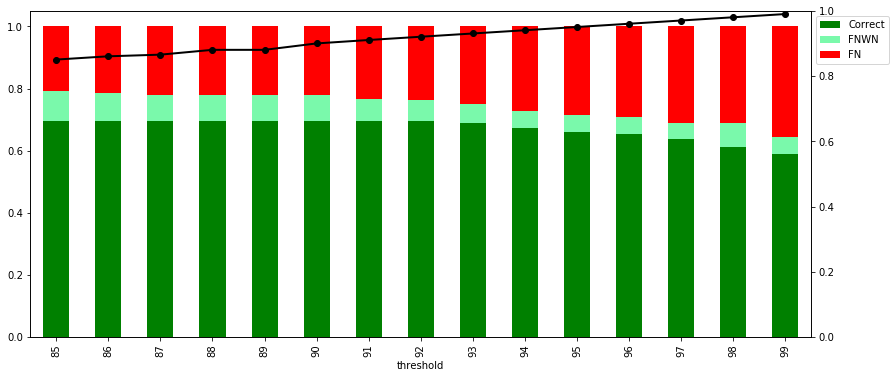

In [32]:
# For model evaluation we only consider the performance over the following victim cell lavels:
# Correct
# False Negative With Neighbor Positive
# False Negative
victim_cells = df_metrics[['Correct','FNWN','FN']] 
victim_cells = victim_cells.div(victim_cells.sum(axis=1), axis=0)

fig = plt.figure()
ax = victim_cells.plot(kind ='bar',stacked=True, figsize=(14, 6), use_index=True,color = ["g","#7af9ab","r"])
ax.legend(loc="best", bbox_to_anchor=(1.0, 1.00))
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),df_metrics['Accuracy'].values, linestyle='-', marker='o', linewidth=2.0, color='black')
ax2.set_ylim(ymin=0, ymax=1)

# Prediction #

We will now make some predictions with our trained model on some test samples and analyze the results.

The pipeline to make a single prediction is the following:

* Make a prediction using the whole dataset of heatmap sequences and select a list of values based on a threshold list.
* Make a prediction using a single selected sequence to predict the selected heatmap on a specific date.
* Convert the analog results into classes according to the threshold list. 
* Normalize all classes between 0 and 1
* Resize the labeled heatmap using linear interpolation to rise the resolution for helping visualization.

In [38]:
# First we search for all values on predicted values on the defined thresholds below
thresholds = find_percentiles(X_test, model, [25,75,91,96])
thresholds.sort()

print("Threshold for 25, 75, 91 and 96 percentile : {0}".format(thresholds))

Threshold for 25, 75, 91 and 96 percentile : [0.00203593575861305, 0.005756543832831085, 0.010972249060869214, 0.03135740995407105]


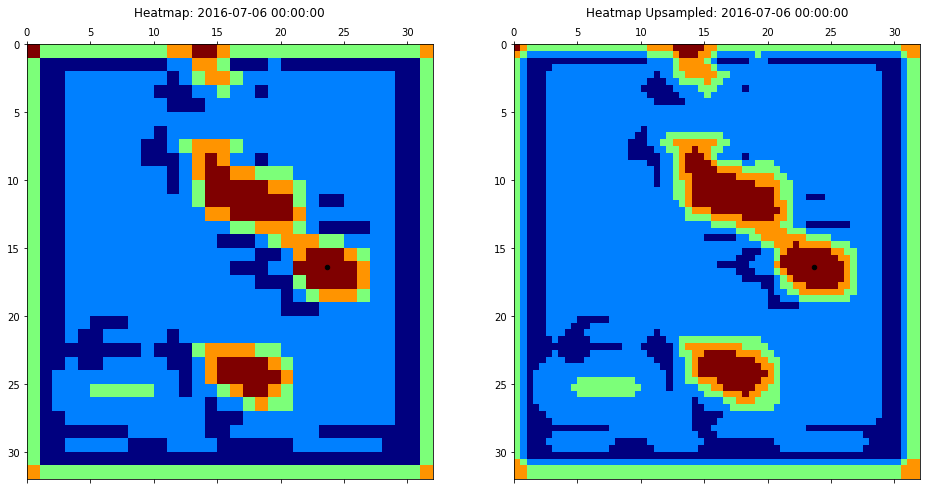

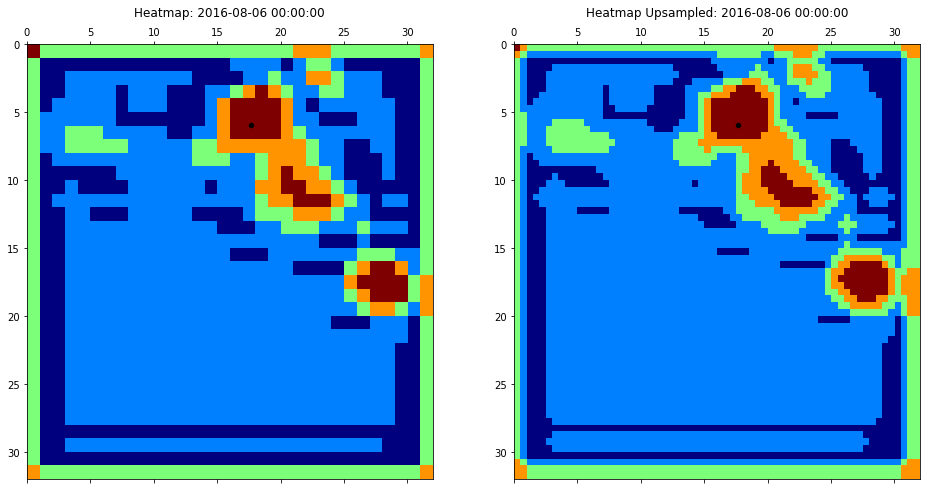

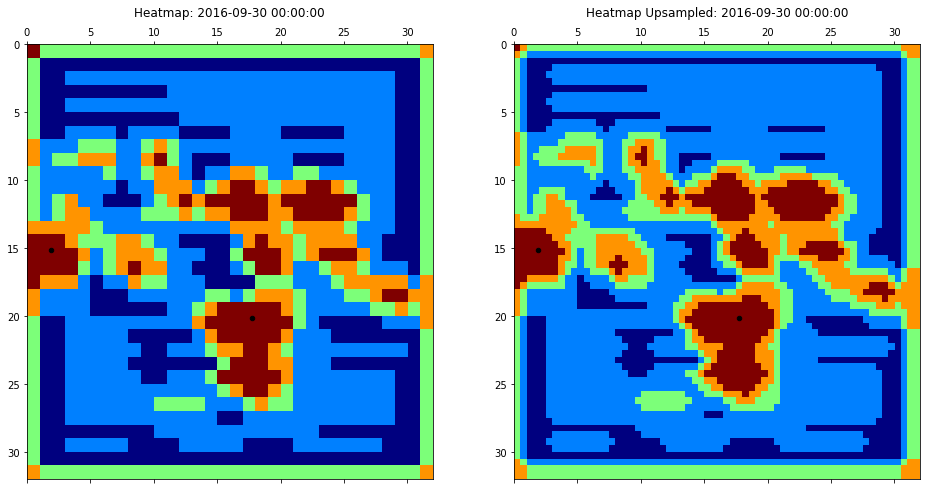

In [44]:
# Plot some samples
n_samples = 3

for i in range(n_samples):

    # Select sample test to evaluate the results
    idx = np.random.randint(0, len(X_test))

    # Get real incidents coordinates to plot on graph
    coords = Y_coords_test[idx]

    # Get incident's date
    date = timestamp_test[idx]

    # Predict heatmap
    heatmap = model.predict(X_test[idx][np.newaxis,...])

    # Remove extra single dimensions
    heatmap = np.squeeze(heatmap)

    # Create a classification based on a list with threshold values
    heatmap[heatmap >= thresholds[3]] = 4
    heatmap[(heatmap >= thresholds[2]) & (heatmap < thresholds[3])] = 3
    heatmap[(heatmap >= thresholds[1]) & (heatmap < thresholds[2])] = 2
    heatmap[(heatmap >= thresholds[0]) & (heatmap < thresholds[1])] = 1
    heatmap[heatmap < thresholds[0]] = 0

    # Resize heatmap with linear interpolation technique to amplify resolution
    heatmap_scal = billinear_interpolation(heatmap,(2 * map_height, 2 * map_width))

    # Normalize heatmap between [0, 1]
    heatmap_norm = (heatmap_scal - heatmap_scal.min()) / (heatmap_scal.max() - heatmap_scal.min())

    # Plot results
    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_figwidth(16)
    f.set_figheight(8)

    ax1.set_title("Heatmap: {0}".format(date))

    ax1.scatter(x=coords[:,1],y=coords[:,0], marker='o', s=20, color='black') 
    ax1.matshow(heatmap, cmap='jet',aspect = ax.get_aspect(), extent = (0,map_height) + (map_width,0))

    ax2.set_title("Heatmap Upsampled: {0}".format(date))

    ax2.scatter(x=coords[:,1],y=coords[:,0], marker='o', s=20, color='black') 
    ax2.matshow(heatmap_norm, cmap='jet',aspect = ax.get_aspect(), extent = (0,map_height) + (map_width,0))

# Prediction with higher threshold  #

Let's make the prediction again using higher threshold list. Instelad of taking the 91th and 96th percentile, we will use the 94th and 99th.

In [45]:
# Rised the thresholds list
thresholds = find_percentiles(X_test, model, [25,75,94,99])
thresholds.sort()

print("Threshold for 25, 75, 94 and 99 percentile : {0}".format(thresholds))

Threshold for 25, 75, 94 and 99 percentile : [0.00203593575861305, 0.005756543832831085, 0.01868795424699781, 0.15036320298910097]


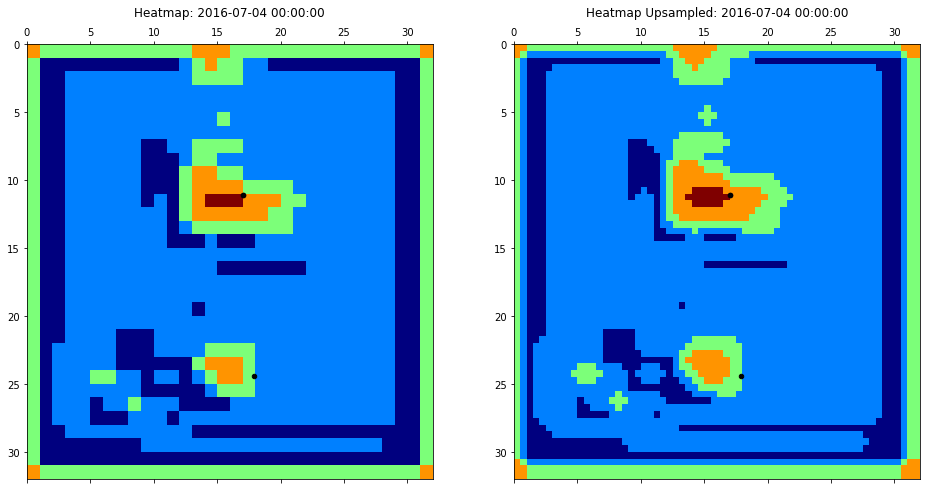

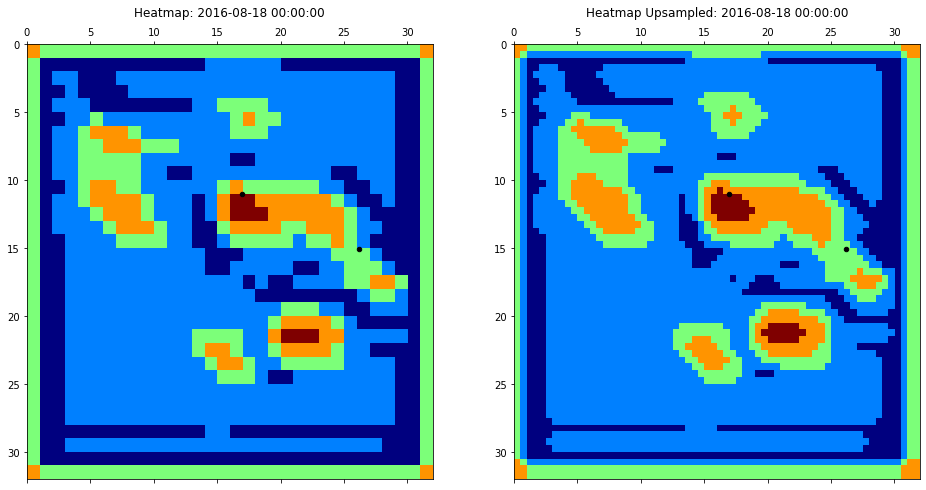

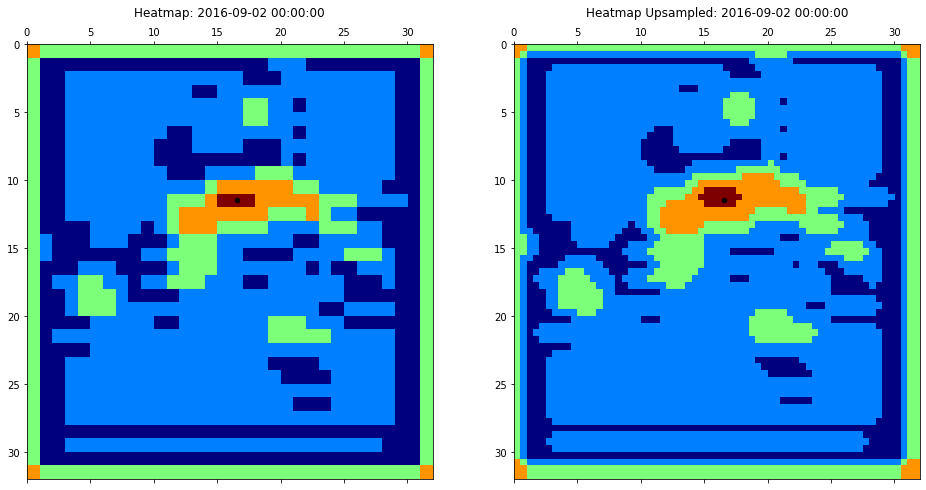

In [46]:
# Plot some samples
n_samples = 3

for i in range(n_samples):

    # Select sample test to evaluate the results
    idx = np.random.randint(0, len(X_test))

    # Get real incidents coordinates to plot on graph
    coords = Y_coords_test[idx]

    # Get incident's date
    date = timestamp_test[idx]

    # Predict heatmap
    heatmap = model.predict(X_test[idx][np.newaxis,...])

    # Remove extra single dimensions
    heatmap = np.squeeze(heatmap)

    # Create a classification based on a list with threshold values
    heatmap[heatmap >= thresholds[3]] = 4
    heatmap[(heatmap >= thresholds[2]) & (heatmap < thresholds[3])] = 3
    heatmap[(heatmap >= thresholds[1]) & (heatmap < thresholds[2])] = 2
    heatmap[(heatmap >= thresholds[0]) & (heatmap < thresholds[1])] = 1
    heatmap[heatmap < thresholds[0]] = 0

    # Resize heatmap with linear interpolation technique to amplify resolution
    heatmap_scal = billinear_interpolation(heatmap,(2 * map_height, 2 * map_width))

    # Normalize heatmap between [0, 1]
    heatmap_norm = (heatmap_scal - heatmap_scal.min()) / (heatmap_scal.max() - heatmap_scal.min())

    # Plot results
    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_figwidth(16)
    f.set_figheight(8)

    ax1.set_title("Heatmap: {0}".format(date))

    ax1.scatter(x=coords[:,1],y=coords[:,0], marker='o', s=20, color='black') 
    ax1.matshow(heatmap, cmap='jet',aspect = ax.get_aspect(), extent = (0,map_height) + (map_width,0))

    ax2.set_title("Heatmap Upsampled: {0}".format(date))

    ax2.scatter(x=coords[:,1],y=coords[:,0], marker='o', s=20, color='black') 
    ax2.matshow(heatmap_norm, cmap='jet',aspect = ax.get_aspect(), extent = (0,map_height) + (map_width,0))

As it is possible to see we increase the number of cells classified and `Neutral` providing a more accurate safe zone for the end user but at the same time we have a chance to miss more incidents.

This is to illustrate the importance between finding a good balance between safety and precision because in the end the success or the failure of all your work will be evaluated using the only metric that matters for your built in application: **RELIABILITY**. Once your end users don't trust any more on what they are seeing it is done, so balance is the key.

# Bibliography #

Holm, Noah;Plynning, E. (2018). Spatio-temporal prediction of residential burglaries using convolutional LSTM neural networks.

Schlegel, U. (2018). Universität Konstanz Department of Computer Science Master Thesis.

Stalidis, P., Semertzidis, T., & Daras, P. (2018). Examining Deep Learning Architectures for Crime Classification and Prediction, 1–12. Retrieved from http://arxiv.org/abs/1812.00602

Wang, B., Zhang, D., Zhang, D., Brantingham, P. J., & Bertozzi, A. L. (2017). Deep Learning for Real Time Crime Forecasting, 33–36. Retrieved from http://arxiv.org/abs/1707.03340

Zhang, J., Zheng, Y., & Qi, D. (2017). Deep spatio-temporal residual networks for citywide crowd flows prediction. 31st AAAI Conference on Artificial Intelligence, AAAI 2017, 1655–1661.